# Prevendo o consumo de eletricidade.

<img src="https://i.imgur.com/wGtGMlK.png" />

Nesse projeto vamos prever o consumo de eletricidade:

* Dataset ele mostra o consumo de eletricidade de 1985 até 2018.
* O objetivo é prever o consumo de eletricidade para os próximos 6 anos, ou seja, até 2024.

Crédito: 

- https://github.com/nageshsinghc4/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

**Utilização do estilo do Five Thirty Eight para visualização dos dados**

https://fivethirtyeight.com/

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
%time df = pd.read_csv('C:/Users/skite/OneDrive/Documentos/GitHub/Projeto_TimeSeries_Cosumo_energia/Electric_Production.csv', sep = ',', encoding  = 'ISO-8859-1')

Wall time: 6 ms


In [5]:
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


### Ajuste dos dados

*Não será necessário grandes ajustes, pois o dataset é relativamente pequeno e não temos dados faltantes.*

**Renomeando as colunas:**

In [9]:
df.columns=['Date', 'Consumption']

**Transformando os dados da coluna Date em Datetime:**

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

**Passando a coluna Date para índice:**

In [12]:
df.set_index('Date', inplace=True)
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Análise exploratória dos dados

**Plot dos dados**

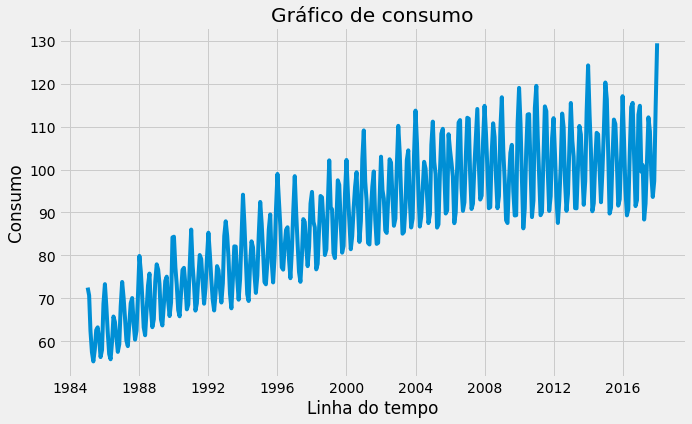

In [16]:
plt.xlabel("Linha do tempo")
plt.ylabel("Consumo")
plt.title("Gráfico de consumo")
plt.plot(df)

*Note que a média não parece ser constante, então será necessário realizar alguma transformação para tornar a curva estacionária.*

**Dispersão do dados**

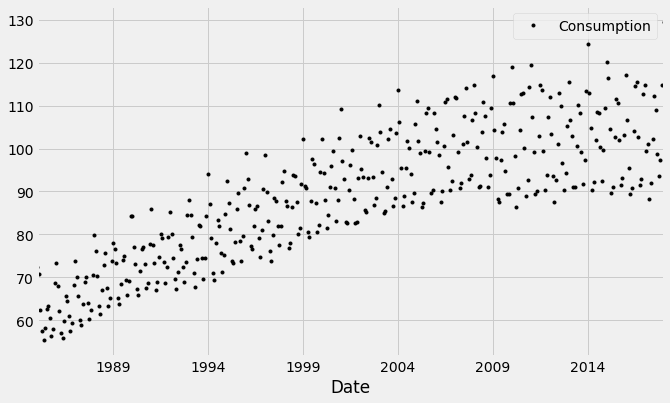

In [20]:
#scatter plot dos dados
df.plot(style='k.')
plt.show()

*Temos dispersão relativa entre os pontos de consumo e também uma tendência de alta.*

**Verificação da distribuição dos dados**

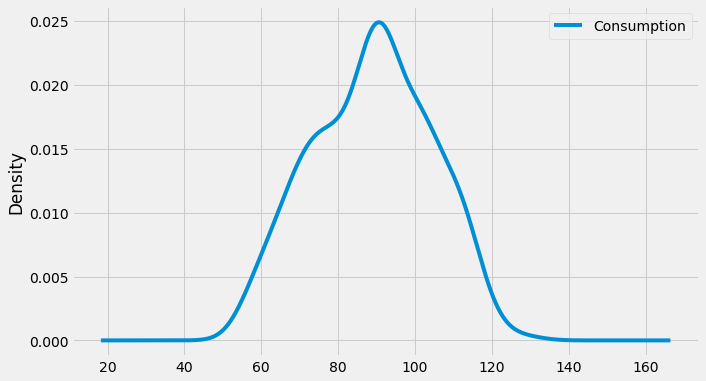

In [22]:
df.plot(kind='kde')

*Já na distribuição de consumo nos temos uma distribuição próxima de uma curva normal*

### Execução da função para verificar se os dados são estacionários

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Estatísticas da Média Móvel
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot dos dados móveis (rolling)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)   

*Teste Dickey Fuller*

In [24]:
print("Results of dickey fuller test")
adft = adfuller(df['Consumption'],autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


* Note que que o p-value é maior que 0,05 portanto não podemos rejeitar a hipótese nula.
* O test Statistics ficou menor que os cirtical value isso indica que os dados não são estacionários.

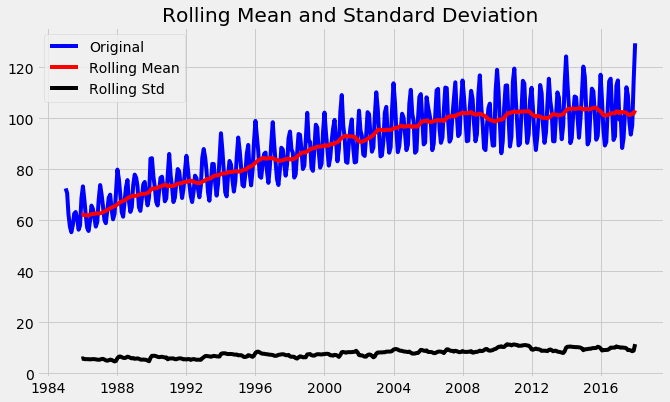

In [25]:
test_stationarity(df)

### Eliminação da tendência

*Uma técnica muito utilizada para reduzer a tendência e aplicar o log à série para reduzir a magnitude dos valores e diminuir a inclinação dos dados no gráfico. Iremos também calcular a média móvel da série.*

**Aplicando Log**

In [26]:
df_log = np.log(df)

**Média Móvel**

In [27]:
moving_avg = df_log.rolling(12).mean()

**Desvio Padrão Móvel**

In [28]:
std_dev = df_log.rolling(12).std()

**Plot dos novos dados**

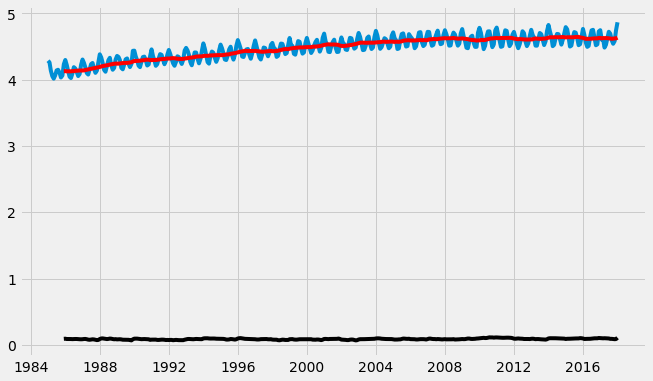

In [30]:
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

*Ok agora podemos eliminar a tendência fazendo a diferenciação dos dados (log) pela média.*

### Diferenciação: Log - Média Móvel

**Diferenciação**

In [32]:
df_log_moving_avg_diff = df_log-moving_avg

In [33]:
df_log_moving_avg_diff.head()

,Consumption
Date,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN


In [34]:
df_log_moving_avg_diff.tail()

,Consumption
Date,
2017-09-01,-0.022477
2017-10-01,-0.076443
2017-11-01,-0.041347
2017-12-01,0.121560
2018-01-01,0.232057


**Drop dos NaN**

In [35]:
df_log_moving_avg_diff.dropna(inplace=True)

**Visualização da transformação**

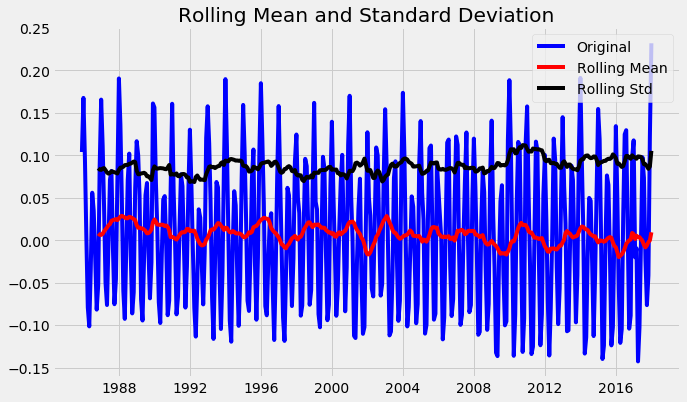

In [36]:
test_stationarity(df_log_moving_avg_diff)

**Fazendo o Teste Dickey Fuller**

In [37]:
print("Results of dickey fuller test")
adft = adfuller(df_log_moving_avg_diff,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


* Note que que o p-value é menor que 0,05 portanto podemos rejeitar a hipótese nula.
* O test Statistics ficou maior que os cirtical value isso indica que os dados está estacionário.

### Também podemos utilizar a suavização: Exponential Weighted Average

*A suavização exponencial, dos pesos ponderados, também pode ser utilizada para estacionar os dados - função ewm()*

*Vamos testa também esse metodo.*

In [39]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
print(weighted_average.head())

            Consumption
Date                   
1985-01-01     4.283658
1985-02-01     4.270484
1985-03-01     4.222468
1985-04-01     4.175897
1985-05-01     4.139460


*A exponential moving average (EMA) é uma média ponderada dos últimos n preços onde o peso diminui exponencialmente com cada passo da série. Ou seja, preços recentes tem um peso maior do que pesos antigos.*

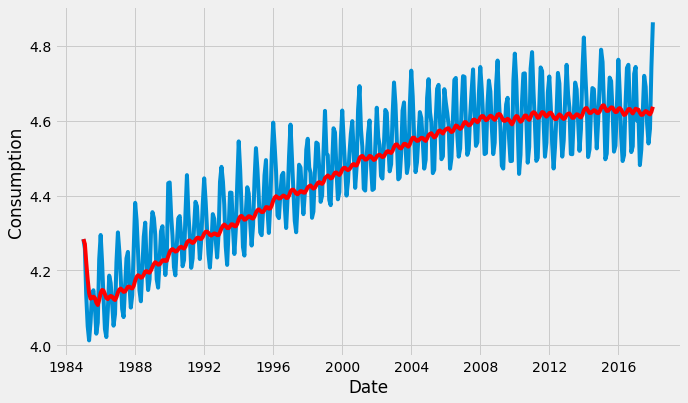

In [40]:
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
#plt.legend()
plt.show(block =False)

**Subtração do log pelo EMA**

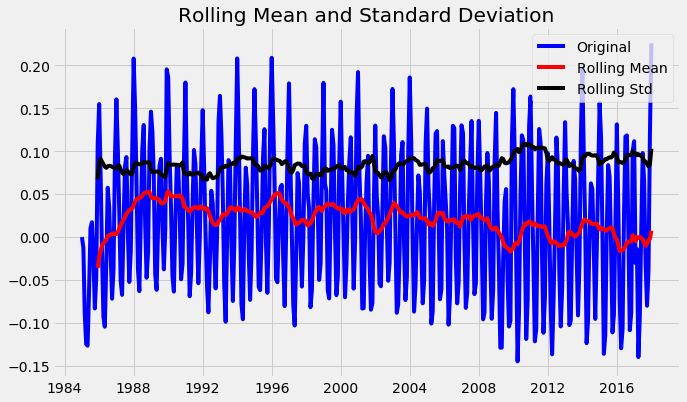

In [41]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

*Note que só  com esse método já tivemos um bom ajuste.*

**Teste Dickey Fuller**

In [42]:
print("Results of dickey fuller test")
adft = adfuller(weighted_average,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -3.577210
p-value                          0.006212
No. of lags used                16.000000
Number of observations used    380.000000
critical value (1%)             -3.447676
critical value (5%)             -2.869176
critical value (10%)            -2.570838
dtype: float64


* Note que agora o p-value é menor que 0,05 portanto podemos rejeitar a hipótese nula.
* O test Statistics ficou maior que os cirtical value isso indica que o dado está estacionário.

### Diferenciação dos dados Log

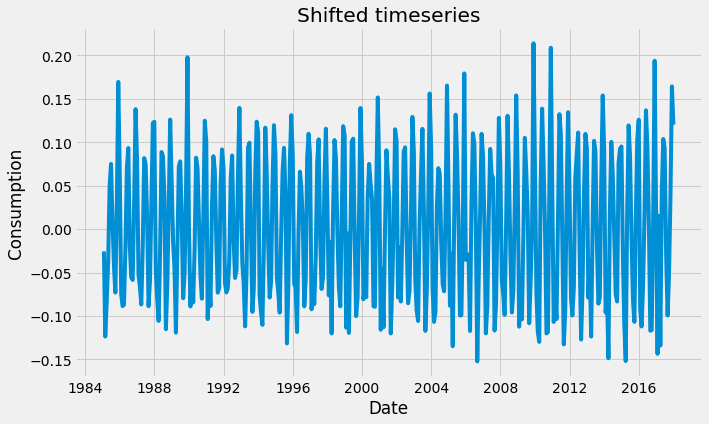

In [44]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

In [47]:
df_log_diff.head()

,Consumption
Date,
1985-01-01,NaN
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242


In [48]:
df_log_diff.tail()

,Consumption
Date,
2017-09-01,-0.099489
2017-10-01,-0.052051
2017-11-01,0.038991
2017-12-01,0.164337
2018-01-01,0.120441


**Eliminação dos NaN**

In [50]:
df_log_diff.dropna(inplace=True)

**Visualização estacionariedade**

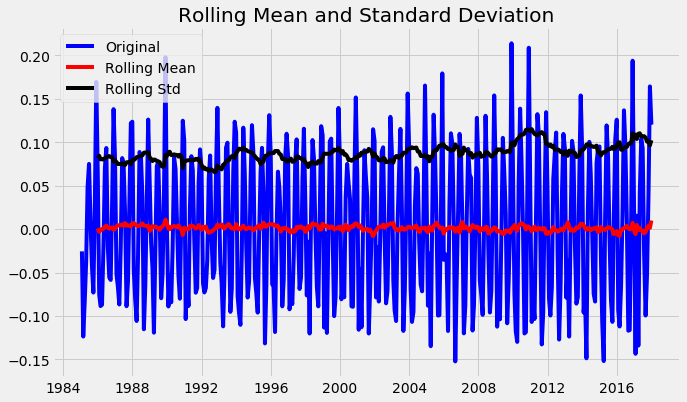

In [52]:
test_stationarity(df_log_diff)

**Teste Dickey Fuller**

In [53]:
print("Results of dickey fuller test")
adft = adfuller(df_log_diff,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


### Decomposição da série com o seasonal_decompose

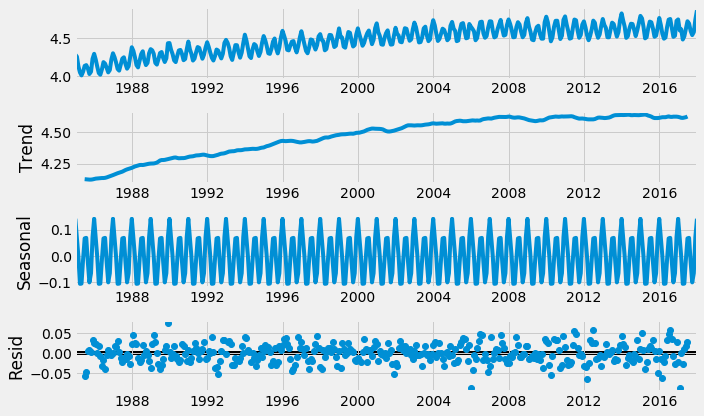

In [54]:
import chart_studio.plotly as py
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

* Como vimos anteriomente temos uma tendência de alta.
* Temos um modelo sazonal. ou seja, a sazonalidade indica um intervalo regular em que o comportamento dos dados se repete.
* Os resíduo também estão comportados.

In [55]:
trend = result.trend
trend.dropna(inplace=True)
trend

Date
1985-07-01    4.126457
1985-08-01    4.125300
1985-09-01    4.123534
1985-10-01    4.123062
1985-11-01    4.123117
                ...   
2017-03-01    4.615421
2017-04-01    4.614662
2017-05-01    4.617567
2017-06-01    4.620230
2017-07-01    4.625917
Name: trend, Length: 385, dtype: float64

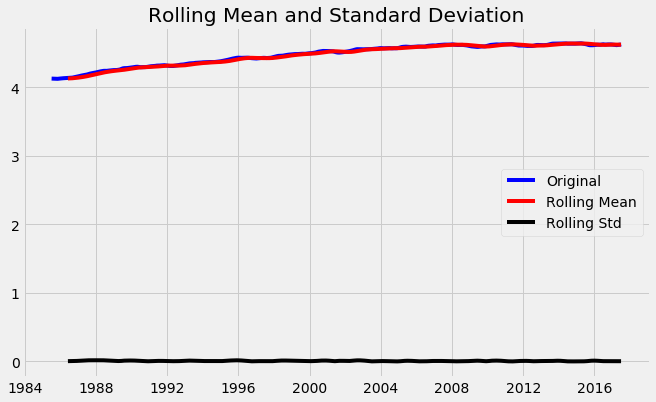

In [56]:
test_stationarity(trend)

In [57]:
seasonality = result.seasonal
seasonality.dropna(inplace=True)
seasonality

Date
1985-01-01    0.142149
1985-02-01    0.066853
1985-03-01   -0.000756
1985-04-01   -0.106579
1985-05-01   -0.105783
                ...   
2017-09-01   -0.025217
2017-10-01   -0.101048
2017-11-01   -0.066002
2017-12-01    0.072225
2018-01-01    0.142149
Name: seasonal, Length: 397, dtype: float64

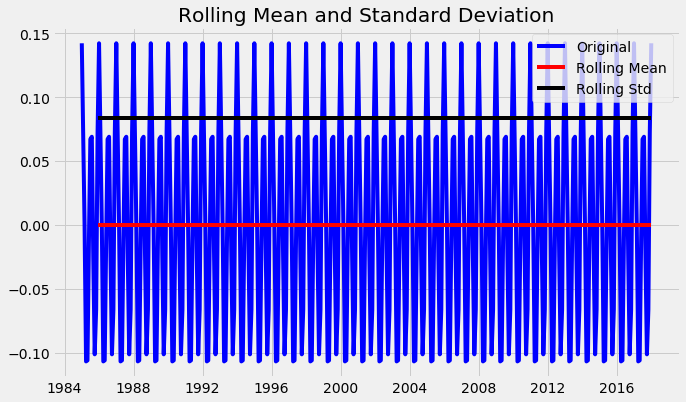

In [58]:
test_stationarity(seasonality)

In [59]:
residual = result.resid
residual.dropna(inplace=True)
residual

Date
1985-07-01   -0.056549
1985-08-01   -0.047294
1985-09-01    0.005724
1985-10-01    0.008954
1985-11-01    0.003336
                ...   
2017-03-01    0.000847
2017-04-01   -0.026743
2017-05-01    0.010879
2017-06-01    0.018331
2017-07-01    0.026774
Name: resid, Length: 385, dtype: float64

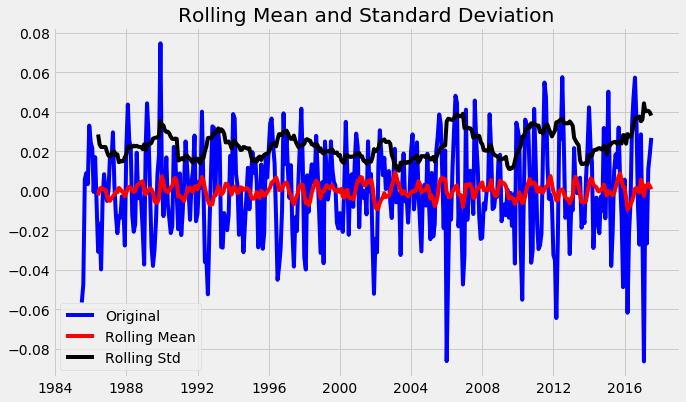

In [60]:
test_stationarity(residual)

## Determinação dos parâmetros do ARIMA (p,d,q)
- p - termo autoregressivo - AR,
- d - diferenciação não sazonal - I I
- q - janela média móvel - MA

Iremos utilizar:

 **ACF - Auto Correlation Function**
  * O coeficiente de correlação entre dois valores em uma Time Series é chamada de Auto Correlation function (ACF). Por exemplo, o ACF de uma série temporal é       dado por:
         
  * ACF = Corr (yt , yt−k)
  * Onde: k é intervalo de tempo entre os dois valores que queremos medir.
  * O resultado do ACF é a correlação (positiva ou negativa) deste intervalo K – considerando toda a série. 
    São levados em consideração os pontos intermediários entre K.

**PACF – Partial Auto Correlation Function**

  * Também há o PACF – que mede a correlação de maneira análoga, mas que não leva em consideração os pontos intermediários.

**Geração dos gráficos ACF e PACF**

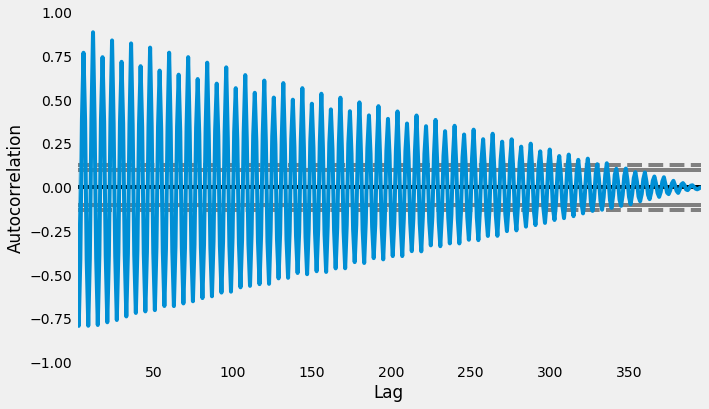

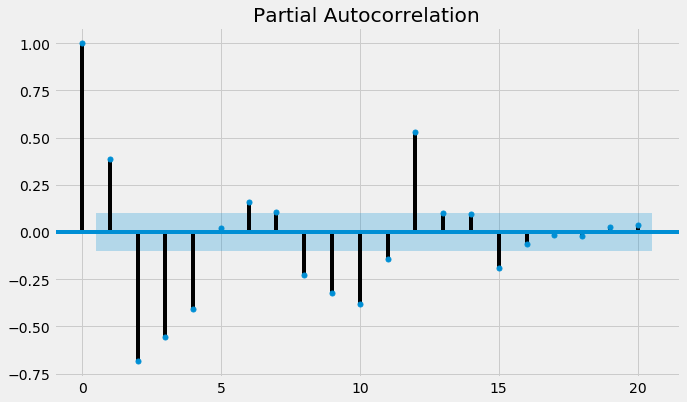

In [64]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
autocorrelation_plot(df_log_diff)
plot_pacf(df_log_diff, lags=20)
plt.show()

*Análisando o grafico lollipop chart nos mostra a quantidade de termos que precisaremos informar*

*Quantidade de termos em p: olhando para o gŕafico de PACF note que apenas um ponto azul passou valor crítico (faixa azulada horizontal) antes de retornarem para dentro da faixa.*

### STATSMODELS

In [65]:
from statsmodels.tsa.stattools import acf,pacf

acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')

**Plot PACF**

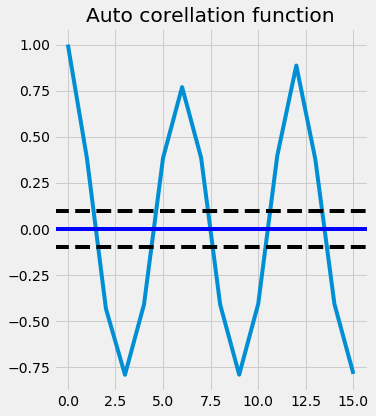

In [66]:
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()

**Plot ACF**

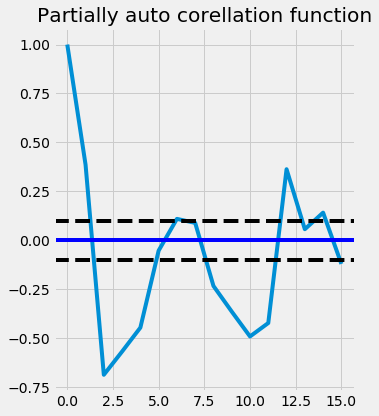

In [67]:
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

*Geração dos resultados - Sum Square Residuals*

## ARIMA

**Modelo ARIMA (AR+ Integrated + MA)**

**Terminologias em ARIMA**

O modelo ARIMA pode ser basicamente resumido por três fatores:

**p** = o número de termos autorregressivos.

* p é o número de termos auto-regressivos (parte AR). Permite incorporar o efeito de valores passados em nosso modelo. Intuitivamente, isso seria semelhante ao afirmar que é provável que esteja quente amanhã se estiver quente nos últimos três dias.

**d** = o número é o fator que vamos aplicar para resolver a estacionaridade.

* d é o número de diferenças não sazonais necessárias para a estacionariedade. Intuitivamente, isso seria semelhante ao afirmar que provavelmente haverá a mesma temperatura amanhã se a diferença de temperatura nos últimos três dias tiver sido muito pequena.

**q** = o número de termos da média móvel.

* q é o número de erros de previsão atrasados na equação de previsão (parte MA). Isso nos permite definir o erro do nosso modelo como uma combinação linear dos valores de erro observados em momentos anteriores no passado.

Estes são os três números inteiros (p, d, q) usados para parametrizar os modelos ARIMA. Portanto, isso é chamado de modelo “ARIMA (p, d, q)”.

In [70]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(4,1,2))
result_AR = model.fit(disp = 0)
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

C:\Users\skite\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\skite\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RSS : 0.510741


C:\Users\skite\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\skite\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**forecast 'prevendo' eletricidade para os próximos 4 meses**

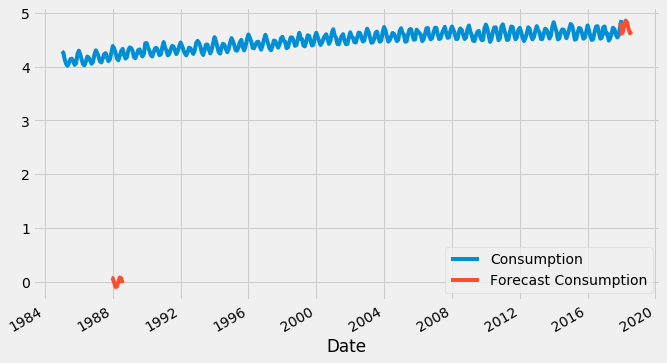

In [71]:
# copia dados
future=df_log
# zera índice
future=future.reset_index()
# seleciona a coluna Date
mon=future["Date"]
# faz o offset da data
mon=mon+pd.DateOffset(months=7)
# seleciona últimos registros
future_dates = mon[-7-1:]
# atribui a data como índice
future = future.set_index('Date')
# monta novo dataframe
newDf = pd.DataFrame(index=future_dates, columns=future.columns)
future = pd.concat([future,newDf])
# faz a predição
future["Forecast Consumption"]= result_AR.predict(start=35, end =43, dynamic=True)
# out of sample forecasts
future["Forecast Consumption"].iloc[-10:]=result_AR.forecast(steps=10)[0]
future[['Consumption','Forecast Consumption']].plot()

In [72]:
future

,Consumption,Forecast Consumption
Date,,
1985-01-01,4.283658,NaN
1985-02-01,4.258049,NaN
1985-03-01,4.134369,NaN
1985-04-01,4.051287,NaN
1985-05-01,4.013046,NaN
...,...,...
2018-04-01,NaN,4.852521
2018-05-01,NaN,4.816387
2018-06-01,NaN,4.698069


## Predição para os próximos 6 anos.

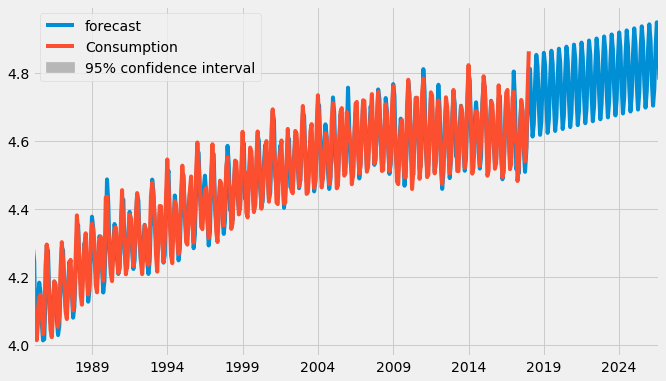

In [74]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)

*Essa é a expectativas do consumo de eletricidade para os próximos 6 anos.*